## List of callbacks
fastai的训练循环具有高度可扩展性，具有丰富的回调系统。 如果您对编写自己的回调感兴趣，请参阅回调文档。 请参阅下文，了解fastai提供的回调列表，按其定义的模块分组。

使用callback_fns参数传递给Learner的每个回调都将自动存储为属性。 属性名称是蛇形的，因此例如ActivationStats将显示为learn.activation_stats（假设您的对象名为learn）。

## Callback
此子包包含更复杂的回调，每个回调都在自己的模块中。 他们是（点击链接了解更多详情）：

### LRFinder
使用Leslie Smith的学习速率查找器来找到训练模型的良好学习率。 让我们看一个使用简单CNN在MNIST数据集上使用的示例。

In [1]:
from fastai.vision import *
from fastai.basics import *
from fastai.callbacks import *

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)
def simple_learner(): 
    return Learner(data, simple_cnn((3,16,16,2)), metrics=[accuracy])
learn = simple_learner()

fastai librairy已经有一个名为lr_find的学习者方法，它使用LRFinder将损失绘制为学习率的函数

In [3]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


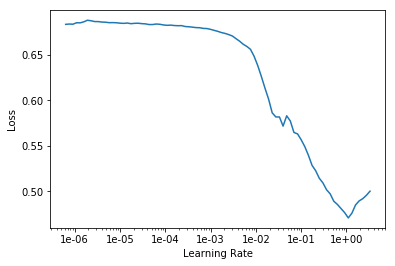

In [4]:
learn.recorder.plot()

在这个例子中，2e-2附近的学习率似乎是合适的。

In [5]:
lr = 2e-2

### OneCycleScheduler
使用Leslie Smith的1循环退火方法进行训练。 让我们使用一个周期策略训练我们的简单学习者。

In [6]:
learn.fit_one_cycle(3, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.111805,0.084633,0.970559,00:59
1,0.050072,0.045795,0.984789,00:57
2,0.032499,0.037358,0.988714,00:56


学习速度和动力在时期内如下改变（专用文档页面上的更多信息）。

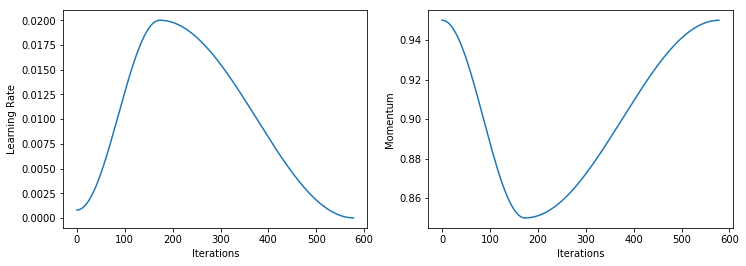

In [7]:
learn.recorder.plot_lr(show_moms=True)

### MixUpCallback
使用混合方法的数据增加：超越经验风险最小化。 在fastai中添加mixup非常简单：

In [8]:
learn = Learner(data, simple_cnn((3, 16, 16, 2)), metrics=[accuracy]).mixup()

### CSVLogger
在csv文件中记录训练结果。 只需将CSVLogger回调传递给`Learner`即可。

In [9]:
learn = Learner(data, simple_cnn((3, 16, 16, 2)), metrics=[accuracy, error_rate], callback_fns=[CSVLogger])

In [10]:
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.130986,0.109607,0.958783,0.041217,00:57
1,0.084719,0.108965,0.963199,0.036801,00:57
2,0.066796,0.053216,0.980864,0.019136,00:57


然后，您可以阅读csv。

In [11]:
learn.csv_logger.read_logged_file()

,epoch,train_loss,valid_loss,accuracy,error_rate
0,0,0.130986,0.109607,0.958783,0.041217
1,1,0.084719,0.108965,0.963199,0.036801
2,2,0.066796,0.053216,0.980864,0.019136


### GeneralScheduler
使用方便的API创建您自己的多阶段退火方案。 为了说明，让我们实施一个两阶段计划。

In [12]:
def fit_odd_shedule(learn, lr):
    n = len(learn.data.train_dl)
    phases = [TrainingPhase(n).schedule_hp('lr', lr, anneal=annealing_cos), 
              TrainingPhase(n*2).schedule_hp('lr', lr, anneal=annealing_poly(2))]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    total_epochs = 3
    learn.fit(total_epochs)

In [13]:
learn = Learner(data, simple_cnn((3,16,16,2)), metrics=accuracy)
fit_odd_shedule(learn, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.174525,0.164080,0.942100,00:57
1,0.151946,0.143329,0.947988,00:57
2,0.138340,0.140380,0.947988,00:58


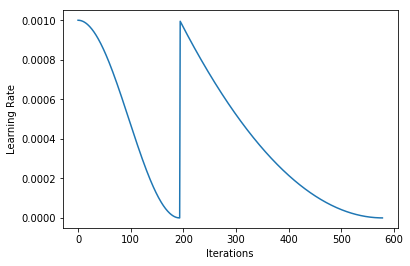

In [14]:
learn.recorder.plot_lr()

### MixedPrecision
使用fp16可以利用最新NVIDIA GPU上的张量核心，获得200％或更高的速度。

### HookCallback
方便的包装器，用于注册和自动注销PyTorch钩子。 还包含预定义的钩子回调：ActivationStats。

### RNNTrainer
回调负责训练RNN的所有调整。

### TerminateOnNaNCallback
如果损失达到NaN，则停止训练。

### EarlyStoppingCallback
如果给定的指标/验证损失没有改善，则停止培训。

### SaveModelCallback
在每个时期保存模型，或者给定度量/验证损失的最佳模型。

In [15]:
learn = Learner(data, simple_cnn((3,16,16,2)), metrics=accuracy)
learn.fit_one_cycle(3,1e-4, callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy')])

epoch,train_loss,valid_loss,accuracy,time
0,0.659855,0.628235,0.866045,00:57
1,0.456108,0.414048,0.929833,00:57
2,0.372098,0.374318,0.928852,00:57


In [16]:
(path/'models').ls()

[WindowsPath('C:/Users/Yang/.fastai/data/mnist_sample/models/bestmodel_0.pth'),
 WindowsPath('C:/Users/Yang/.fastai/data/mnist_sample/models/bestmodel_1.pth'),
 WindowsPath('C:/Users/Yang/.fastai/data/mnist_sample/models/bestmodel_2.pth'),
 WindowsPath('C:/Users/Yang/.fastai/data/mnist_sample/models/tmp.pth'),
 WindowsPath('C:/Users/Yang/.fastai/data/mnist_sample/models/trained_model.pth')]

### ReduceLROnPlateauCallback
每当给定的度量/验证损失没有因特定因素而改善时，降低学习率。

### PeakMemMetric
GPU和通用RAM分析回调

### StopAfterNBatches
在第一个时期的n批次之后停止训练。

## train and basic_train
### Recorder
跟踪每批次和每个`epoch`的平滑损失和指标。

### ShowGraph
在培训期间动态显示学习图表。

### BnFreeze
冻结不可训练层的batchnorm层移动平均值统计。

### GradientClipping
在训练期间剪辑渐变。